## Final Machine Learning Pipeline
The pipeline features: 

* open source classes
* in-house package classes
* only uses the selected features

### Rossman Store Sales Prediction
The aim of the project is to build an end-to-end machine learning model to predict the sales of a given store and a set of inputs, including the promotions, competition, school and state holidays, seasonality, and locality.

In [78]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [79]:
# load dataset
df_sales = pd.read_csv('train.csv')
df_store = pd.read_csv('store.csv')

# Merge
df_raw = pd.merge( df_sales, df_store, how = 'left', on = 'Store' )

# drop all rows with zero Sales amount
df_raw = df_raw[df_raw['Sales'] > 0]

print(df_raw.info())
df_raw.head()

C:\Users\benja\anaconda3\envs\test-ml-gcash-rossmann-research\lib\site-packages\IPython\core\interactiveshell.py:3012: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 759848 entries, 0 to 914610
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      759848 non-null  int64  
 1   DayOfWeek                  759848 non-null  int64  
 2   Date                       759848 non-null  object 
 3   Sales                      759848 non-null  int64  
 4   Customers                  759848 non-null  int64  
 5   Open                       759848 non-null  int64  
 6   Promo                      759848 non-null  int64  
 7   StateHoliday               759848 non-null  object 
 8   SchoolHoliday              759848 non-null  int64  
 9   StoreType                  759848 non-null  object 
 10  Assortment                 759848 non-null  object 
 11  CompetitionDistance        757889 non-null  float64
 12  CompetitionOpenSinceMonth  518054 non-null  float64
 13  CompetitionOpenSinceYear   51

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-04-30,6228,650,1,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4,2015-04-30,6884,716,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,4,2015-04-30,9971,979,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,2015-04-30,16106,1854,1,1,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,2015-04-30,6598,729,1,1,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Separate dataset into train and test
When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

* mean
* mode
* exponents from the yeo-johnson
* category frequency
* and category to number mappings

from the train set.

In [80]:
# separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    df_raw.drop(['Store', 'Sales'], axis=1), # predictive variables
    df_raw['Sales'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((607878, 16), (151970, 16))

In [81]:
#  transform datatype of the variable date to datetime
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_test['Date'] = pd.to_datetime(X_test['Date'])

# year
X_train['year'] = X_train['Date'].dt.year
X_test['year'] = X_test['Date'].dt.year

### Target

In [82]:
# for target, we apply the logarithm (log1p)
y_train = np.log1p(y_train) # = np.log(y_train + 1)
y_test = np.log1p(y_test)

### Configuration

In [83]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_MISSING = ['PromoInterval']

# numerical variables with NA in train set
# NUMERICAL_VARS_WITH_NA = ['Promo2SinceWeek', 'Promo2SinceYear',
#                           'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
#                           'CompetitionDistance']
NUMERICAL_VARS_WITH_NA = ['Promo2SinceWeek', 'CompetitionOpenSinceYear','CompetitionDistance']


NUMERICAL_VARS_IMPUTE_MEAN = ['CompetitionDistance']
# NUMERICAL_VARS_IMPUTE_MODE = ['Promo2SinceWeek', 'Promo2SinceYear',
#                           'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
NUMERICAL_VARS_IMPUTE_MODE = ['Promo2SinceWeek', 'CompetitionOpenSinceYear']


# TEMPORAL_VARS = ['CompetitionOpenSinceYear', 'Promo2SinceYear']
TEMPORAL_VARS = ['CompetitionOpenSinceYear']
REF_VAR = "year"   
# DROP_VARS = ['Date','Promo2SinceWeek','year', 'Promo2SinceWeek_na']   
DROP_VARS = ['Date', 'year']

# variables to log transform
NUMERICALS_LOG_VARS = ["Customers"]

NUMERICALS_YEO_VARS = ['CompetitionDistance']

# variables to map
ASSORT_VARS = ['Assortment']
ASSORT_MAPPINGS = {'a':1, 'b':2, 'c': 3}

# categorical variables to encode
CATEGORICAL_VARS = ['StateHoliday', 'StoreType', 'PromoInterval']

# the selected variables
FEATURES = [
    'Date',
    'DayOfWeek',
    'Customers',
    'Open',
    'Promo',
    'StateHoliday',
    # 'SchoolHoliday',
    'StoreType',
    'Assortment',
    'CompetitionDistance',
    # 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2',
    'Promo2SinceWeek',
    # 'Promo2SinceYear',
    'PromoInterval',
    # this one is only to calculate the temporal variable:
    'year'
]

In [84]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((607878, 14), (151970, 14))

### Pipeline - End-to-end

In [85]:
# use ColumnTransformer passing a SimpleImputer

mode_imputer = ColumnTransformer([
        ('imputation',
         SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
          NUMERICAL_VARS_IMPUTE_MODE)
    ], remainder='passthrough')

In [86]:
# create final pipeline with the feature engineering and feature seelction steps
sales_pipe = Pipeline([
    # ===== IMPUTATION =====
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_IMPUTE_MEAN)),
    

    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),
    ('drop_features', DropFeatures(features_to_drop=DROP_VARS)),    


    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),


    # === mappers ===
    ('mapper_assort', pp.Mapper(
        variables=ASSORT_VARS, mappings=ASSORT_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS)),
    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),

    # impute numerical variables with the mode
    ('mode_imputer', mode_imputer),   

    ('scaler', MinMaxScaler()),
    ('Lasso', Lasso(alpha=0.001, random_state=0))
])

In [87]:
# train the pipeline
sales_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['Promo2SinceWeek',
                                                'CompetitionOpenSinceYear',
                                                'CompetitionDistance'])),
                ('missing_imputation',
                 CategoricalImputer(variables=['PromoInterval'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['CompetitionDistance'])),
                ('elapsed_time',
                 TemporalVariableTransformer...
                                             'PromoInterval'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['StateHoliday', 'StoreType',
                                           'PromoInterval'])),
                ('mode_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imput

In [88]:
# evaluate the model:
# ====================

# remember that we log transformed the output (Sales)

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original store sales values.

# Evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = sales_pipe.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = sales_pipe.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average store sales: ', int(np.exp(y_train).median()))

train mse: 2111335
train rmse: 1453
train r2: 0.7808872628586598

test mse: 2095628
test rmse: 1447
test r2: 0.7839967272439753

Average store sales:  6341


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

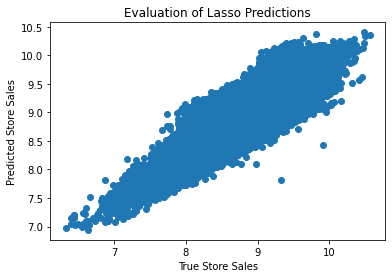

In [89]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, sales_pipe.predict(X_test))
plt.xlabel('True Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Evaluation of Lasso Predictions')

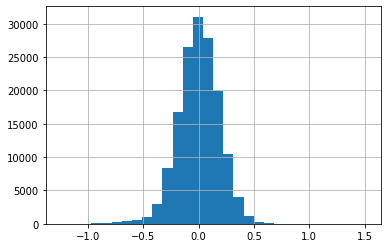

In [90]:
# Evaluate the distribution of the errors: 
# they should be fairly normally distributed
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(sales_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [91]:
# save the pipeline
joblib.dump(sales_pipe, 'sales_pipeline.joblib')

['sales_pipeline.joblib']